## Project description


Main objectives is to compile a list of hypotheses that may help boost revenue of online store (prioritize hypotheses, launch an A/B test, and analyze the results).


## Part 1. Prioritizing Hypotheses

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import datetime as dt
import scipy.stats as stats

In [2]:
data_hypothesis = pd.read_csv('hypotheses_us.csv', delimiter=';')
pd.set_option('max_colwidth', 400)
data_hypothesis

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


### Apply the ICE framework to prioritize hypotheses. Sort them in descending order of priority.

In [3]:
data_hypothesis['ICE'] = data_hypothesis['Impact']*data_hypothesis['Confidence']/data_hypothesis['Effort'] 
data_hypothesis['ICE'].sort_values(ascending=False)


8    16.200000
0    13.333333
7    11.200000
6     8.000000
2     7.000000
1     2.000000
5     1.333333
3     1.125000
4     1.000000
Name: ICE, dtype: float64

ICE method shows that the most promising hypotheses are number 8, 0, 7, 6.

### Apply the RICE framework to prioritize hypotheses. Sort them in descending order of priority.

In [4]:
data_hypothesis['RICE'] = data_hypothesis['Reach']*data_hypothesis['Impact']*data_hypothesis['Confidence']/data_hypothesis['Effort']
data_hypothesis['RICE'].sort_values(ascending=False)


7    112.0
2     56.0
6     40.0
0     40.0
8     16.2
3      9.0
5      4.0
1      4.0
4      3.0
Name: RICE, dtype: float64

RICE method also shows that hypotheses number 7, 6, 0 are the most promising. But now on the first place is number 7. And instead of number 8 we see number 2 in the first four best hypotheses.

### Show how the prioritization of hypotheses changes when you use RICE instead of ICE. Provide an explanation for the changes.

In [5]:
data_hypothesis.head(9)

,Hypothesis,Reach,Impact,Confidence,Effort,ICE,RICE
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.333333,40.0
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.000000,4.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.000000,56.0
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.125000,9.0
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.000000,3.0
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.333333,4.0
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.000000,40.0
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.200000,112.0
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.200000,16.2


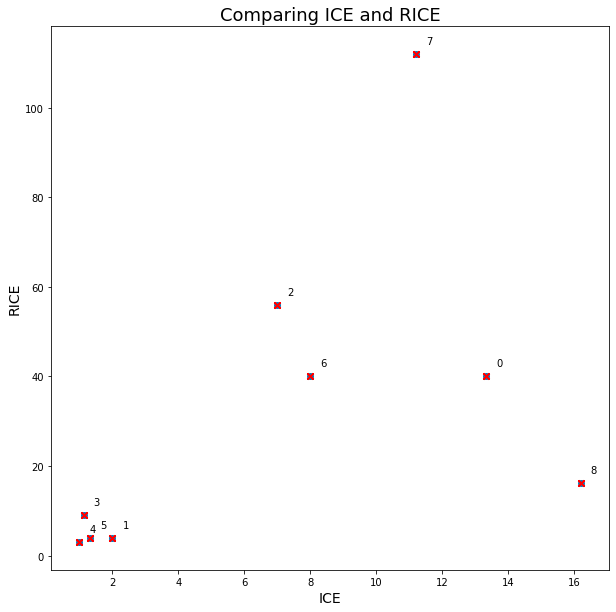

In [6]:
x = data_hypothesis['ICE'].values
y = data_hypothesis['RICE'].values
types = data_hypothesis.index

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y)

ax.set_xlabel('ICE', fontsize=14)
ax.set_ylabel('RICE', fontsize=14)
ax.set_title('Comparing ICE and RICE', fontsize=18)

for i, txt in enumerate(types):
    ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
    plt.scatter(x, y, marker='x', color='red')

We can see that for the hypothesis number 8 results of applying ICE and RICE frameworks are the same. Because the Reach parameter equal 1. At the same time for the hypothesis number 7 the value of RICE is 10 times greater that ICE, because the Reach parameter equal 10. The RICE change is influenced by how many users will be affected.

## Part 2

### General information and preparing the data for an A/B test analyze

In [7]:
#reading the data 'orders'
orders = pd.read_csv('/datasets/orders_us.csv')
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null float64
group            1197 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


For correct A/B test user should not appear in more than one group. So to keep correctness we decided to drop users wich appear in both groups.

In [9]:
#getting a list of the users in group A
list_A = orders.query('group == "A"')['visitorId'].tolist()
#getting a list of the users in group B
list_B = orders.query('group == "B"')['visitorId'].tolist()

#finding users which appear in both groups
intersection_set = set.intersection(set(list_A), set(list_B))
intersection_list = list(intersection_set)

#making a new dataframe without users which appear in both groups
orders_new = orders.query('visitorId not in @intersection_list')
orders_new.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [10]:
orders_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1016 non-null int64
visitorId        1016 non-null int64
date             1016 non-null datetime64[ns]
revenue          1016 non-null float64
group            1016 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 47.6+ KB


In [11]:
visits = pd.read_csv('/datasets/visits_us.csv')
visits['date'] = visits['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [12]:
# building an array with unique paired date-group values
datesGroups = orders_new[['date','group']].drop_duplicates()
datesGroups.head()

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


In [13]:
# getting aggregated cumulative daily data on orders 
ordersAggregated = datesGroups.apply(lambda x: orders_new[np.logical_and(orders_new['date'] <= x['date'], orders_new['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
ordersAggregated.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,2266.6
66,2019-08-01,B,17,17,967.2
175,2019-08-02,A,42,36,3734.9
173,2019-08-02,B,40,39,3535.3
291,2019-08-03,A,66,60,5550.1


In [14]:
# getting aggregated cumulative daily data on visits  
visitorsAggregated = datesGroups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visits' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAggregated.head()

,date,group,visits
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [15]:
# merging the two tables into one and giving its columns descriptive names
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visits']
cumulativeData.head(5) 

,date,group,orders,buyers,revenue,visits
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845


## Analyze the A/B test:

### 1. Graph cumulative revenue by group. Make conclusions and conjectures.

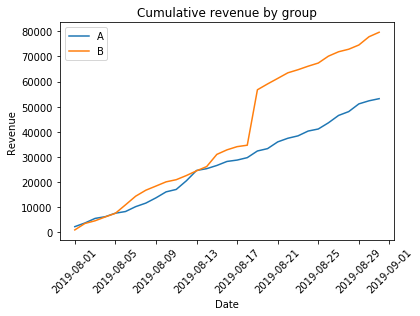

In [16]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# DataFrame with cumulative orders and cumulative revenue by day, group A
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# DataFrame with cumulative orders and cumulative revenue by day, group B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Plotting the group A revenue graph 
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Plotting the group B revenue graph 
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xticks(rotation=45)

plt.title('Cumulative revenue by group')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend() 
plt.show()



Revenue is rising steadily throughout the whole test. That's a good sign. Only at the beggining of the graph segments A and B are the same and then segment B constantly lead. In the second part of the graph there is a significant increase in revenue in the group B. This may imply either a surge in the number of orders or the presence of very expensive orders in the sample.


### 2. Graph cumulative average order size by group. Make conclusions and conjectures.

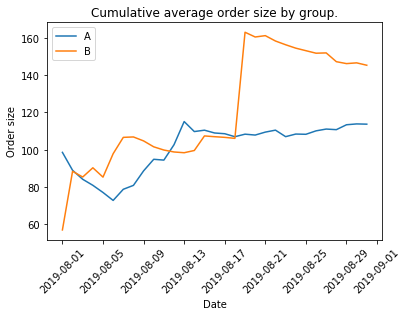

In [17]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Order size')
plt.title('Cumulative average order size by group.')
plt.show()


On this graph we also see the significant jump in orders for the segment B.

### 3. Graph the relative difference in cumulative average order size for group B compared with group A. Make conclusions and conjectures.

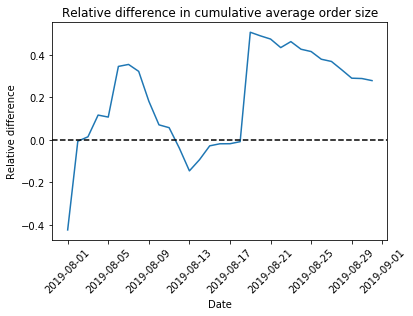

In [18]:
# gathering the data into one DataFrame
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# plotting a relative difference graph for the average purchase sizes
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# adding the X axis
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Relative difference in cumulative average order size')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Relative difference')
plt.show()

At several points the difference between the segments spikes. This means there may be some big orders and outliers.

### 4. Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. Draw conclusions and make conjectures.

In [19]:
cumulativeData.head()

,date,group,orders,buyers,revenue,visits
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845


['2019-08-01', '2019-08-31', 0, 0.1]

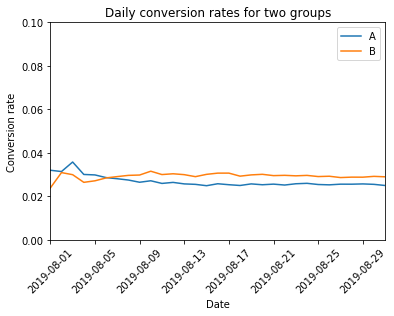

In [20]:
# calculating cumulative conversion
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visits']

# selecting data on group A 
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# selecting data on group B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
# plotting the graphs
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('Daily conversion rates for two groups')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Conversion rate')
# setting the axes' scale
plt.axis(["2019-08-01", '2019-08-31', 0, 0.1]) 

After some hesitation at first, then the chart looks fairly stable. When the conversion rate for group B is higher than for group A.

['2019-08-01', '2019-08-31', -0.6, 0.6]

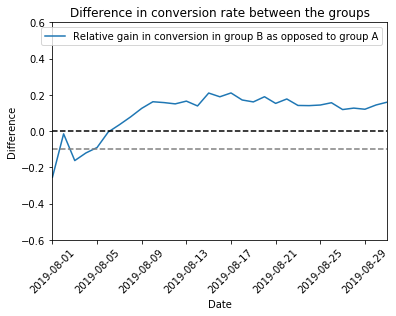

In [21]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Relative gain in conversion in group B as opposed to group A")
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Difference')
plt.title('Difference in conversion rate between the groups')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.6, 0.6]) 

The graph of the difference in conversion between the groups shows that results of the group B are better than those of group A.

### 5. Plot a scatter chart of the number of orders per user. Make conclusions and conjectures.

In [22]:
ordersByUsers = orders_new.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsers.columns = ['userId','orders']
ordersByUsers.sort_values(by='orders',ascending=False).head(10) 

,userId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


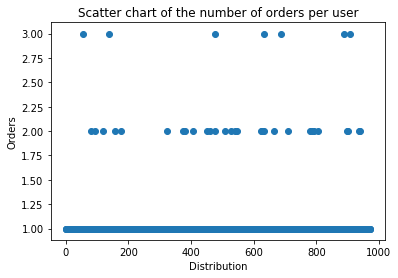

In [23]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Scatter chart of the number of orders per user')
plt.ylabel('Orders')
plt.xlabel('Distribution')
plt.show()

We can conclude that the most of users make one order. But also there are indeed a lot of users with two to three orders. The exact share remains unknown, since it's not clear whether we should consider them anomalies or not.

### 6. Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.

In [24]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

Not more than 5% of users placed more than 1 orders, and only 1% of users made more than 2.
Thus, it would be reasonable to set two orders per user as the lower limit for the number of orders and to filter anomalies on that basis. 

### 7. Plot a scatter chart of order prices. Make conclusions and conjectures.

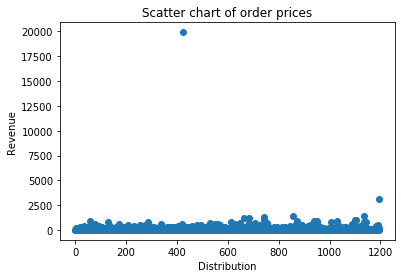

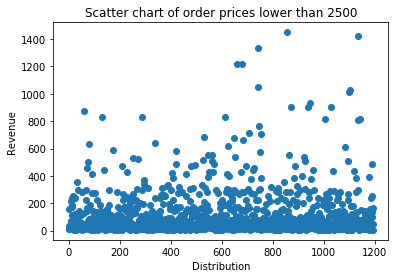

In [25]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.title('Scatter chart of order prices')
plt.ylabel('Revenue')
plt.xlabel('Distribution')
plt.show()

x_values = pd.Series(range(0, len(orders.query('revenue < 2500')['revenue'])))
plt.scatter(x_values, orders.query('revenue < 2500')['revenue']) 
plt.title('Scatter chart of order prices lower than 2500')
plt.ylabel('Revenue')
plt.xlabel('Distribution')
plt.show()

On the scatterplot we see a few outliers above 1500. Among them we can notice one a very expensive order, which revenue is about 20000.

### 8. Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.

In [26]:
np.percentile(orders_new['revenue'], [95, 99])

array([414.275, 830.3  ])

Not more than 5% of orders cost more than 414.28, and not more than 1% cost more than 830.3.

We can specify as abnormal point orders with price higher than 1500. 

### 9. Find the statistical significance of the difference in conversion between the groups using the raw data. Make conclusions and conjectures.

In [27]:
orders_new.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [28]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [29]:
#creating the variables ordersByUsersA and ordersByUsersB to store the columns ['visitorId', 'orders'].
ordersByUsersA = orders_new[orders_new['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = orders_new[orders_new['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders'] 


**Formulating hypotheses**

Null hypothesis H₀: there's not a statistically significant difference in conversion between the groups A and B. 

Alternative hypothesis H₁: there is a statistical significant difference in conversion between of the groups A and B.

alpha = 0,05

if pvalue is lower than alpha, we can reject null hypothesis.
if pvalue is greater than alpha, we can not reject null hypothesis.

In [30]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, True, 'two-sided')[1]))

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

0.011
0.160


The p-value is significantly lower than 0.05, so we reject the null hypothesis. The raw data analysis showed that the conversion rates of the groups have statistically significant differences. The relative conversion gain for group B compared with group A is 16%


### 10. Find the statistical significance of the difference in average order size between the groups using the raw data. Make conclusions and conjectures.

**Formulating hypotheses**

Null hypothesis H₀: there's not a statistically significant difference between the average order size of the groups A and B.

Alternative hypothesis H₁: there is a statistical significant difference between the average order size of the groups A and B.

alpha = 0,05

if pvalue is lower than alpha, we can reject null hypothesis.
if pvalue is greater than alpha, we can not reject null hypothesis.

In [31]:
print("{0:.3f}".format(stats.mannwhitneyu(orders_new[orders_new['group']=='A']['revenue'], orders_new[orders_new['group']=='B']['revenue'], True, 'two-sided')[1]))
print("{0:.3f}".format(orders_new[orders_new['group']=='B']['revenue'].mean()/orders_new[orders_new['group']=='A']['revenue'].mean()-1)) 


0.862
0.278


The p-value is higher than 0.05, so there are no statistically significant differences between the average order sizes of the groups. The relative difference is 27.8%

### 11. Find the statistical significance of the difference in conversion between the groups using the filtered data. Make conclusions and conjectures.

We can define anomalous users as those who place more than two orders or one order bigger than 19.000. Thus we'll remove the 5% of users with the largest numbers of orders and from 1% to 5% of the users with the most expensive orders. For this goal we make data slices with the users who placed more than two orders (usersWithManyOrders) and the users who placed orders for more than 19.000 (usersWithExpensiveOrders). We'll join them in a table called abnormalUsers.


In [32]:
ordersByUsersA.head()

,visitorId,orders
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1


In [33]:
#slicing the data (users who place more than two orders or one order bigger than 19.000)
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'], ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId']], axis = 0)
usersWithExpensiveOrders = orders_new[orders_new['revenue'] > 19000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
abnormalUsers.head()

33      249864742
58      611059232
425    1920142716
211    2108163459
347    2742574263
Name: visitorId, dtype: int64

In [34]:
abnormalUsers.shape

(8,)

We have 8 anomalous users in total.

We'll calculate the statistical significance of the differences in conversion between the groups, using filtered data. 

**Formulating hypotheses**

Null hypothesis H₀: there's not a statistically significant difference in conversion between the groups A and B. 

Alternative hypothesis H₁: there is a statistical significant difference in conversion between of the groups A and B.


alpha = 0,05

if pvalue is lower than alpha, we can reject null hypothesis.
if pvalue is greater than alpha, we can not reject null hypothesis.

In [35]:
#preparing samples of the number of orders per user for each test group
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0) 


In [36]:
#appling the statistical Mann-Whitney criterion to the resulting samples
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, True, 'two-sided')[1]))
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 


0.009
0.183


The results for conversion almost didn't change. The filtered data analysis showed that the conversion rates of the groups have statistically significant differences. The relative conversion gain for group B compared with group A is 16.8%. 

### 12. Find the statistical significance of the difference in average order size between the groups using the filtered data. Make conclusions and conjectures.

**Formulating hypotheses**

Null hypothesis H₀: there's not a statistically significant difference between the average order size of the groups A and B.

Alternative hypothesis H₁: there is a statistical significant difference between the average order size of the groups A and B.

alpha = 0,05

if pvalue is lower than alpha, we can reject null hypothesis.
if pvalue is greater than alpha, we can not reject null hypothesis.

In [37]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null float64
group            1197 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


In [38]:
print("{0:.3f}".format(stats.mannwhitneyu(
    orders_new[np.logical_and(
        orders_new['group']=='A',
        np.logical_not(orders_new['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders_new[np.logical_and(
        orders_new['group']=='B',
        np.logical_not(orders_new['visitorId'].isin(abnormalUsers)))]['revenue'], True, 'two-sided')[1]))

print("{0:.3f}".format(
    orders_new[np.logical_and(orders_new['group']=='B',np.logical_not(orders_new['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders_new[np.logical_and(
        orders_new['group']=='A',
        np.logical_not(orders_new['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 


0.711
-0.042


The p-value is almost the same. We can conclude that there are no statistically significant differences between the average order sizes of the groups in filtered data.  The relative difference is 4%

### 13. Make a decision based on the test results. The possible decisions are: 1. Stop the test, consider one of the groups the leader. 2. Stop the test, conclude that there is no difference between the groups. 3. Continue the test.

What facts we have:

1. The graph of cumulutive revenue by group shows that the group B constantly lead. 


2. The conversion rate for group B is higher than for group A. And the chart is stable.


3. The graph of the difference in conversion between the groups shows that group B's results are better than those of group A.

We can make a general conclusion that the group B is better than group A, we should stop the test.